# Pylops - Bayesian seismic inversion

### Author: M.Ravasi

In this notebook we consider the post-stack inverse problem in a Bayesian setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.linalg import lstsq, toeplitz, cholesky, cholesky_banded
from scipy.sparse import csr_matrix, vstack, spdiags
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *

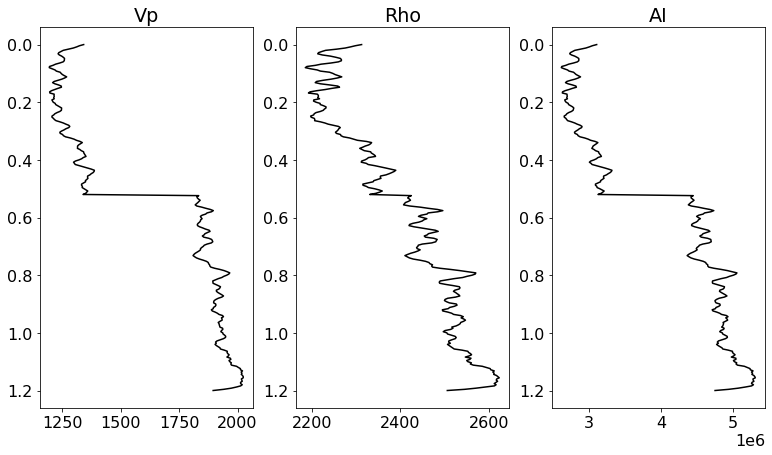

In [2]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
vs  = 600  + vp/2           + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 20, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
vp[131:]+=500
vs[131:]+=200
rho[131:]+=100
# Model and background  model
m1d = np.log(vp*rho).flatten()

nsmooth = 100
m1dback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m1d)

fig, axs = plt.subplots (1, 3, figsize=(13,7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(rho, t0, 'k')
axs[1].set_title('Rho')
axs[1].invert_yaxis()
axs[2].plot(rho*vp, t0, 'k')
axs[2].set_title('AI')
axs[2].invert_yaxis()

Define wavelet

In [3]:
nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0

ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

Define prior model and data

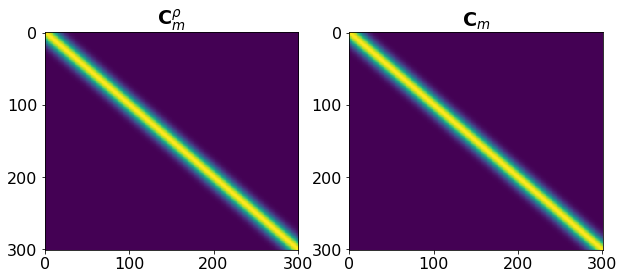

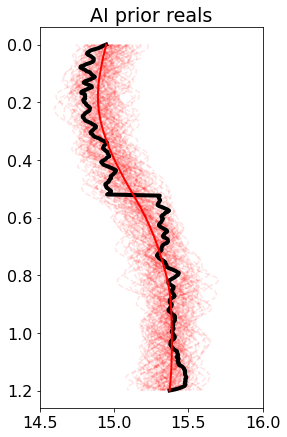

In [4]:
# Mean
m0 = m1dback

# Correlation and covariance functions
corrrange = .1
sigma_m = 1e-1
corr_t0 = np.arange(nt0)*dt0
 
corr = np.exp(-3*(corr_t0)**2/corrrange**2)
Corr = toeplitz(corr)
Std = np.diag(sigma_m*np.ones(Corr.shape[0]))
Cm = np.dot(Std, np.dot(Corr, Std))
Cm_sqrt = cholesky(Cm + 1e-5*np.eye(nt0), lower=True)

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax1.imshow(Corr, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{\rho}$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.imshow(Cm, interpolation='nearest')
ax2.set_title(r"$\mathbf{C}_m$")
ax2.axis('tight');

# Prior realizations
nreals=100
mreals = (m1dback[:, np.newaxis] + ((Cm_sqrt @ np.random.normal(0, 1, (nt0, nreals))))).T

# Visualize
fig, ax = plt.subplots (1, 1, figsize=(4,7))
ax.plot(mreals.T,  t0, '--r', alpha=0.1)
ax.plot(m1d,  t0, 'k', lw=4)
ax.plot(m1dback,  t0, 'r', lw=2)
ax.set_xlim(14.5, 16)
ax.set_title('AI prior reals')
ax.invert_yaxis()

We do the same now with banded and sparse matrices to save memory. This will be the only valid strategy in multiple dimensions (2d and 3d)

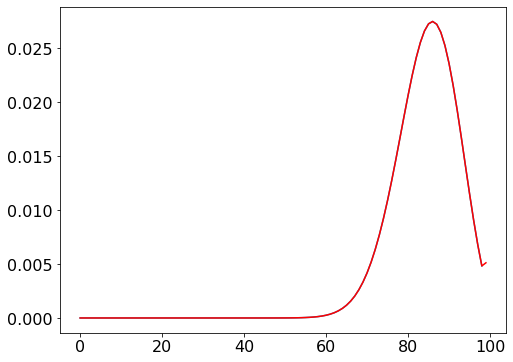

In [5]:
# create banded matrix
nband = 100
Cm_band = np.zeros((nband, nt0))

for i in range(nband):
    Cm_band[-1 - i][i:] = np.diagonal(Cm, offset=i)
Cm_band[-1] += 1e-5

# apply Cholesky to banded matrix
Cm_sqrt_band = cholesky_banded(Cm_band, lower=False)

plt.figure()
plt.plot(Cm_sqrt[nt0//2][nt0//2 - nband + 1:nt0//2])
plt.plot(Cm_sqrt_band[:, nt0//2], 'r')

# convert lower cholesky into sparse matrix
Cm_sqrt_band = spdiags(Cm_sqrt_band, np.arange(-nband, 0, 1) + 1, nt0, nt0)

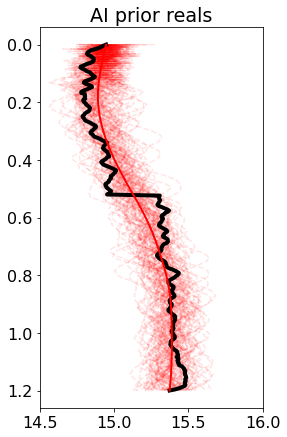

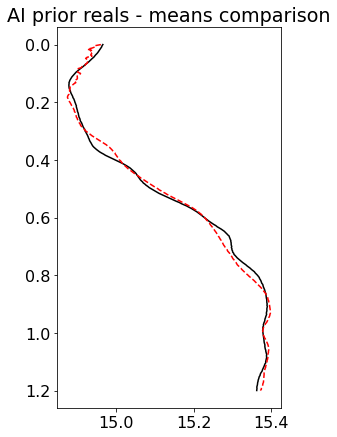

In [6]:
# Prior realizations
mreals_band = (m1dback[:, np.newaxis] + ((Cm_sqrt_band @ np.random.normal(0, 1, (nt0, nreals))))).T

# Visualize
fig, ax = plt.subplots (1, 1, figsize=(4,7))
ax.plot(mreals_band.T,  t0, '--r', alpha=0.1)
ax.plot(m1d,  t0, 'k', lw=4)
ax.plot(m1dback,  t0, 'r', lw=2)
ax.set_xlim(14.5, 16)
ax.set_title('AI prior reals')
ax.invert_yaxis()

fig, ax = plt.subplots (1, 1, figsize=(4,7))
ax.plot(np.mean(mreals, axis=0),  t0, 'k')
ax.plot(np.mean(mreals_band, axis=0),  t0, '--r',)
ax.set_title('AI prior reals - means comparison')
ax.invert_yaxis()

## Post-stack inversion - 1D

In [7]:
# lop
PPop = PoststackLinearModelling(wav, nt0=nt0)
dottest(PPop, nt0, nt0, verb=True)

# data
sigmad = 2e-2

d = PPop*m1d
dn = d + np.random.normal(0, sigmad, d.shape)

Dot test passed, v^H(Opu)=9.484309727707972 - u^H(Op^Hv)=9.484309727707975


Deterministic inversion

In [8]:
d0 = PPop*m1dback
dr = dn - d0

minv = normal_equations_inversion(PPop, dr, None, epsI=1e-1, **dict(maxiter=100))[0]
minv = m1dback + minv

Bayesian inversion:

$$\mathbf{m} = \mathbf{m_0} + (\mathbf{R} \mathbf{C}_m \mathbf{R}^T + \mathbf{C}_d)^{-1} (\mathbf{d} - \mathbf{R} \mathbf{m_0})$$

In [9]:
nband = 80
Cm_op = \
    (sigma_m * Identity(nt0)) * \
    Convolve1D(nt0, Corr[nt0//2, nt0//2-nband:nt0//2 +nband+1], offset=nband) * \
    (sigma_m * Identity(nt0))

Cd_op = (sigmad**2) * Identity(nt0)

mbayes = m1dback + Cm_op * PPop.H * (lsqr(PPop * Cm_op * PPop.H + Cd_op, dn - PPop*m1dback, 
                                          iter_lim=100)[0])

In [10]:
mbayesreals = [mreal + Cm_op * PPop.H * (lsqr(PPop * Cm_op * PPop.H + Cd_op, dn - PPop*mreal, 
                                          iter_lim=100)[0]) for mreal in mreals]
mbayesreals = np.array(mbayesreals)

# Estimate sample covariance and mean (and for prior)
m0_post = np.average(mbayesreals, axis=0)
Cm_post = ((mbayesreals - m0_post).T @ (mbayesreals - m0_post))/nreals

m0_prior = np.average(mreals, axis=0)
Cm_prior = ((mreals - m0_prior).T @ (mreals - m0_prior))/nreals

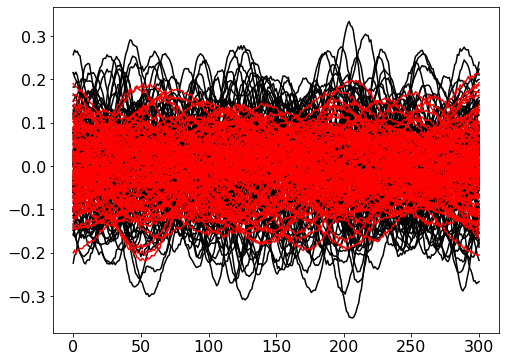

In [11]:
plt.figure()
plt.plot((mreals - m0_prior).T, 'k')
plt.plot((mbayesreals - m0_post).T, 'r');

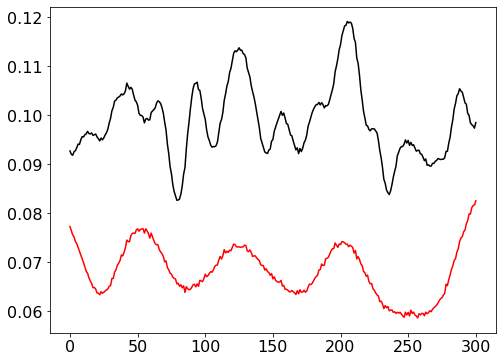

In [12]:
plt.figure()
plt.plot(np.std((mbayesreals - m0_post), axis=0), 'r')
plt.plot(np.std((mreals - m0_prior), axis=0), 'k');

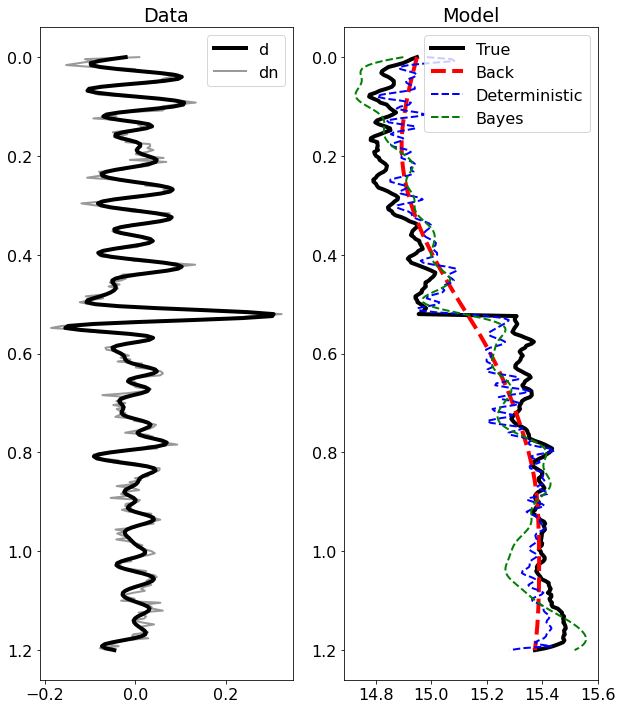

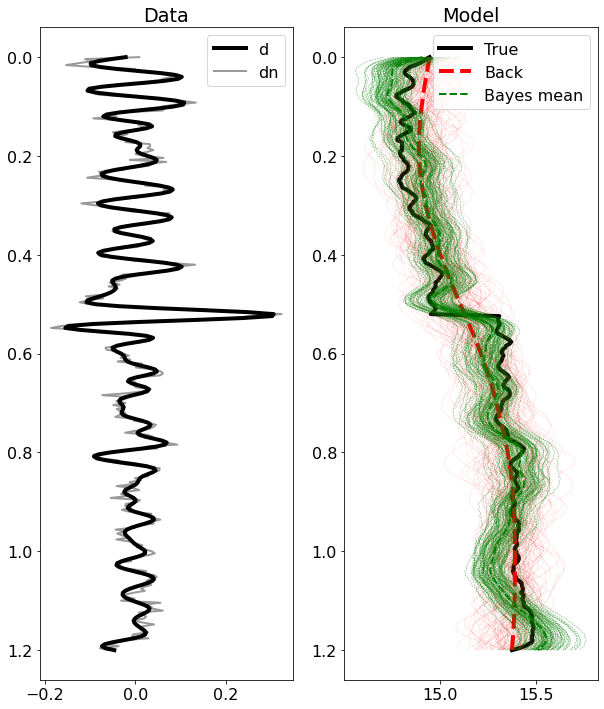

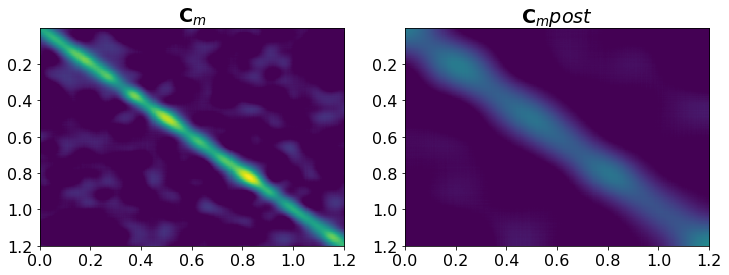

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='d')
axs[0].plot(dn, t0, 'k', lw=2, alpha=0.4, label='dn')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d, t0, 'k', lw=4, label='True')
axs[1].plot(m1dback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=2, label='Deterministic')
axs[1].plot(mbayes, t0, '--g', lw=2, label='Bayes')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='d')
axs[0].plot(dn, t0, 'k', lw=2, alpha=0.4, label='dn')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d, t0, 'k', lw=4, label='True')
axs[1].plot(mreals.T, t0, '--r', lw=0.5, alpha=0.2)
axs[1].plot(m1dback, t0, '--r', lw=4, label='Back')
axs[1].plot(mbayesreals.T, t0, '--g', lw=0.5, alpha=0.6)
axs[1].plot(m0_post, t0, '--g', lw=2, label='Bayes mean')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.imshow(Cm_prior, interpolation='nearest', vmin=0, vmax=Cm_prior.max(), 
           extent=(t0[0], t0[-1], t0[-1], t0[1]))
ax1.set_title(r"$\mathbf{C}_m$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.imshow(Cm_post, interpolation='nearest', vmin=0, vmax=Cm_prior.max(),
           extent=(t0[0], t0[-1], t0[-1], t0[1]))
ax2.set_title(r"$\mathbf{C}_m post$")
ax2.axis('tight');

## Post-stack inversion - 2D

In [14]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'][::5], model['z'][::5], np.log(model['model'])[::5, ::5]
nx, nz = len(x), len(z)

z = np.arange(nz)
x = np.arange(nx)

Define prior model and data

In [15]:
nsmooth = 20
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)

In [16]:
def cov_mat(x, corrrange, std, nb=100):
    """Create correlation matrix and cholesky (square-root) of covariance matrix"""
    nx = x.size
    corr = np.exp(-3*(x)**2/corrrange**2)
    Corr = toeplitz(corr)
    Std = np.diag(std*np.ones(Corr.shape[0]))
    Cm = np.dot(Std, np.dot(Corr, Std))

    # create banded matrix
    Cm_band = np.zeros((nb, nx))    
    for i in range(nb):
        Cm_band[-1 - i][i:] = np.diagonal(Cm, offset=i)
    Cm_band[-1] += 1e-5

    # apply Cholesky to banded matrix
    Cm_sqrt_band = cholesky_banded(Cm_band, lower=False)

    # convert lower cholesky into sparse matrix
    Cm_sqrt_band = spdiags(Cm_sqrt_band, np.arange(-nb, 0, 1) + 1, nx, nx)
    Cm_sqrt_op = MatrixMult(Cm_sqrt_band)
    return Corr, Cm_sqrt_op

In [17]:
# Mean
m0 = mback.copy()

# Correlation and covariance functions
corrrange = [8, 10]
sigma_m = 9e-2

Corr_z, Cm_sqrt_z = cov_mat(z, corrrange[0], np.sqrt(sigma_m))
Corr_x, Cm_sqrt_x = cov_mat(x, corrrange[1], np.sqrt(sigma_m))
Cm_sqrt = Kronecker(Cm_sqrt_z, Cm_sqrt_x)

# Prior realizations
nreals=10
mreals = ((Cm_sqrt @ np.random.normal(0, 1, (nz*nx, nreals)))).T
mreals = m0[np.newaxis, :, :] + mreals.reshape(nreals, nz , nx)
m0 = mreals.mean(axis=0)

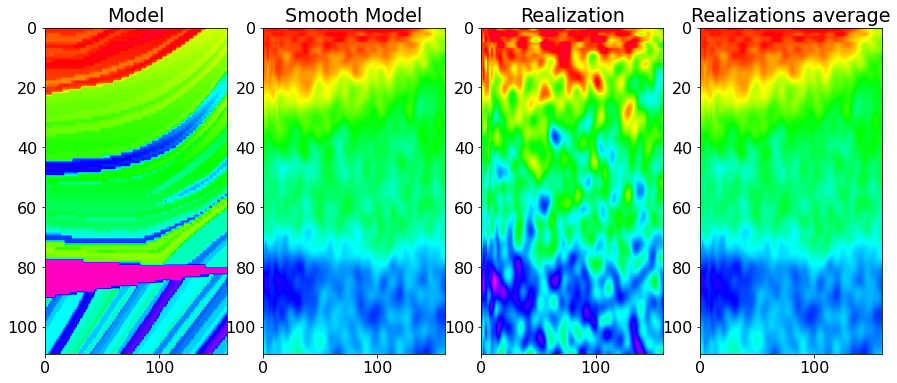

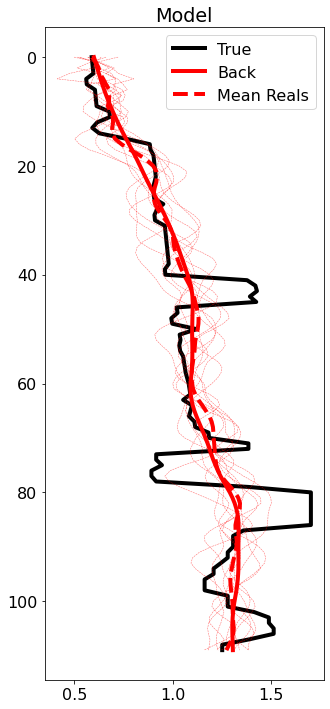

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(15,6))
axs[0].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(m0, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[1].set_title('Smooth Model')
axs[1].axis('tight')
axs[2].imshow(mreals[0], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[2].set_title('Realization')
axs[2].axis('tight')
axs[3].imshow(np.mean(mreals, axis=0), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[3].set_title('Realizations average')
axs[3].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, 'r', lw=4, label='Back')
ax.plot(m0[:,nx//2], z, '--r', lw=4, label='Mean Reals')
ax.plot(mreals[:,:,nx//2].T, z, '--r', lw=0.5, alpha=0.6)
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

Create operators

In [19]:
PPop = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=False)
dottest(PPop, nz*nx, nz*nx, verb=True, atol=1e-3)

# data
sigmad = 1e-3
d = (PPop*m.flatten()).reshape(nz,nx)
n = np.random.normal(0, sigmad, d.shape)
dn = d + n

d0 = PPop * mback.flatten()

Dot test passed, v^H(Opu)=-299.6987839251783 - u^H(Op^Hv)=-299.69878392517813


Deterministic inversion

In [20]:
# solve all rows indipendently
dr = dn - d0.reshape(nz,nx)

# solve all rows together with regularization
D2op  = Laplacian([nz, nx], dtype='float64')

minv = normal_equations_inversion(PPop, dr.flatten(), [D2op], epsI=1e-1,
                                  epsRs=[np.sqrt(1e-4)],
                                  **dict(maxiter=100))[0]
minv = mback + minv.reshape(nz, nx)

Bayesian inversion

In [21]:
Cm_op = Cm_sqrt.H * Cm_sqrt
Cd_op = 3 * (sigmad**2) * Identity(nx*nz) # seems like we need to overestimate the noise to give extra damping

mbayes = mback.flatten() + Cm_op * PPop.H * (lsqr(PPop * Cm_op * PPop.H + Cd_op, 
                                                  dn.flatten() - PPop*mback.flatten(), 
                                                  iter_lim=100)[0])
mbayes = mbayes.reshape(nz, nx)

In [22]:
mbayesreals = \
    [mreal.flatten() + Cm_op * PPop.H * (lsqr(PPop * Cm_op * PPop.H + Cd_op, 
                                              dn.flatten() - PPop*mreal.flatten(), 
                                              iter_lim=200)[0]) for mreal in mreals]
mbayesreals = np.array(mbayesreals).reshape(nreals, nz, nx)

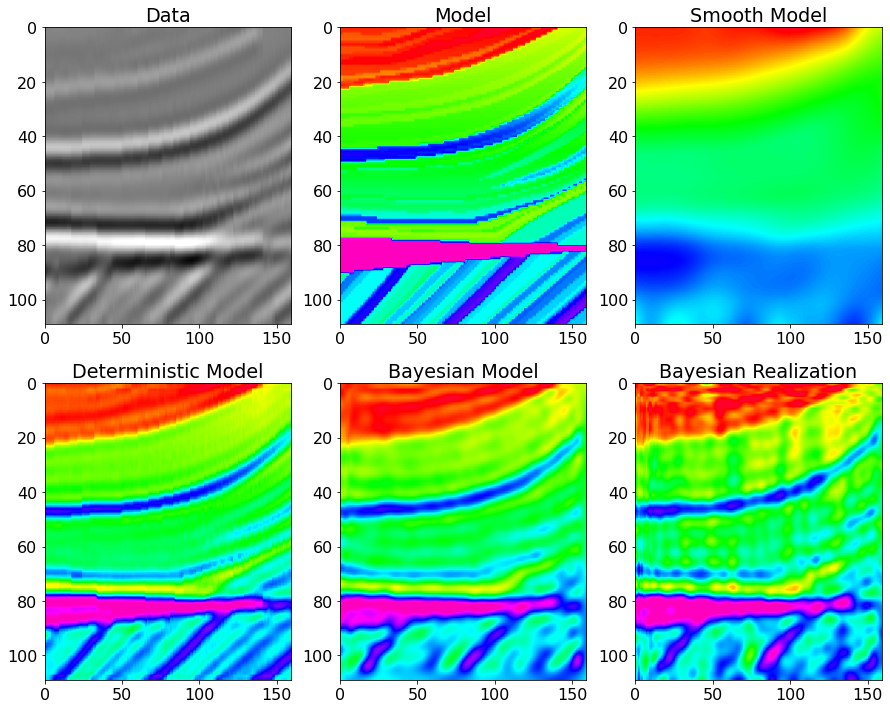

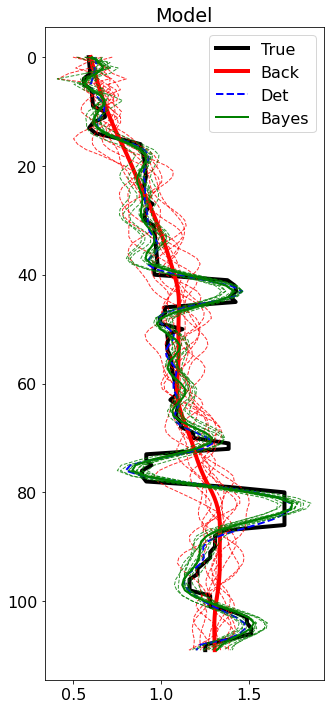

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(dn, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(minv, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Deterministic Model')
axs[1][0].axis('tight')
axs[1][1].imshow(mbayes, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Bayesian Model')
axs[1][1].axis('tight')
axs[1][2].imshow(mbayesreals[0], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Bayesian Realization')
axs[1][2].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2], z, 'r', lw=4, label='Back')
ax.plot(mreals[:, :, nx//2].T, z, '--r', lw=1., alpha=0.8)
ax.plot(minv[:,nx//2], z, '--b', lw=2, label='Det')
ax.plot(mbayes[:,nx//2], z, 'g', lw=2, label='Bayes')
ax.plot(mbayesreals[:, :, nx//2].T, z, '--g', lw=1., alpha=0.8)
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

In [24]:
# Estimate sample covariance and mean (and for prior) for a 1d pillar
mreals1d = mreals[...,nx//2]
mbayesreals1d = mbayesreals[...,nx//2]

m0_post = np.average(mbayesreals1d, axis=0)
Cm_post = ((mbayesreals1d - m0_post).T @ (mbayesreals1d - m0_post))/nreals

m0_prior = np.average(mreals1d, axis=0)
Cm_prior = ((mreals1d - m0_prior).T @ (mreals1d - m0_prior))/nreals

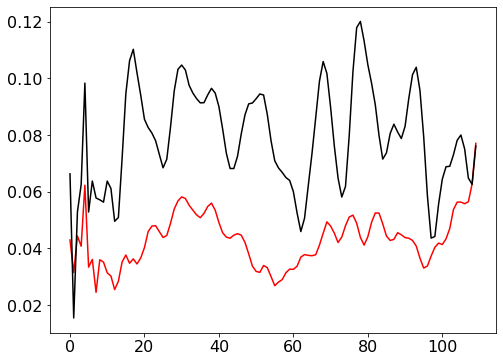

In [25]:
plt.figure()
plt.plot(np.std((mbayesreals1d - m0_post), axis=0), 'r')
plt.plot(np.std((mreals1d - m0_prior), axis=0), 'k');

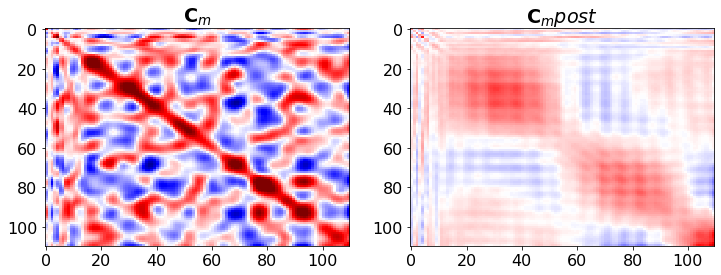

In [26]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.imshow(Cm_prior, cmap='seismic', interpolation='nearest', 
           vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max())
ax1.set_title(r"$\mathbf{C}_m$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.imshow(Cm_post, cmap='seismic', interpolation='nearest',
           vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max())
ax2.set_title(r"$\mathbf{C}_m post$")
ax2.axis('tight');

In [27]:
# Estimate sample covariance and mean (and for prior)
m0_post = np.average(mbayesreals, axis=0)
Cm_post = ((mbayesreals.reshape(nreals, nz*nx) - m0_post.flatten()).T @ (mbayesreals.reshape(nreals, nz*nx) - m0_post.flatten()))/nreals
Cm_prior = ((mreals.reshape(nreals, nz*nx) - mback.flatten()).T @ (mreals.reshape(nreals, nz*nx) - mback.flatten()))/nreals

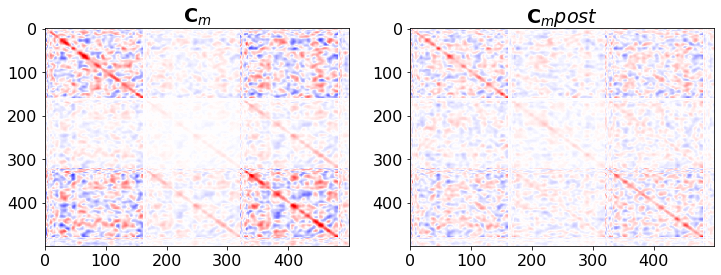

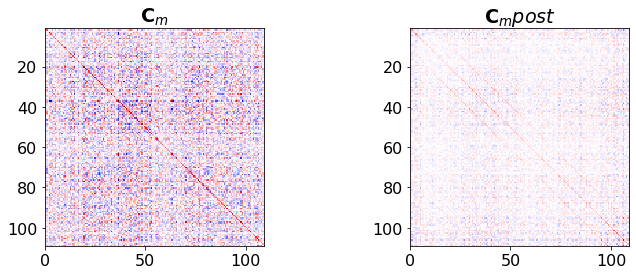

In [28]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.imshow(Cm_prior[:500, :500], cmap='seismic', interpolation='nearest', 
           vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max())
ax1.set_title(r"$\mathbf{C}_m$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.imshow(Cm_post[:500, :500], cmap='seismic', interpolation='nearest', 
           vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max())
ax2.set_title(r"$\mathbf{C}_m post$")
ax2.axis('tight');

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax1.imshow(Cm_prior[::nz, ::nz], cmap='seismic', interpolation='nearest',          
           vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max(), 
           extent=(z[0], z[-1], z[-1], z[1]))
ax1.set_title(r"$\mathbf{C}_m$");
ax2 = plt.subplot(122)
ax2.imshow(Cm_post[::nz, ::nz], cmap='seismic', interpolation='nearest',          
           vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max(), 
           extent=(z[0], z[-1], z[-1], z[1]))
ax2.set_title(r"$\mathbf{C}_m post$");

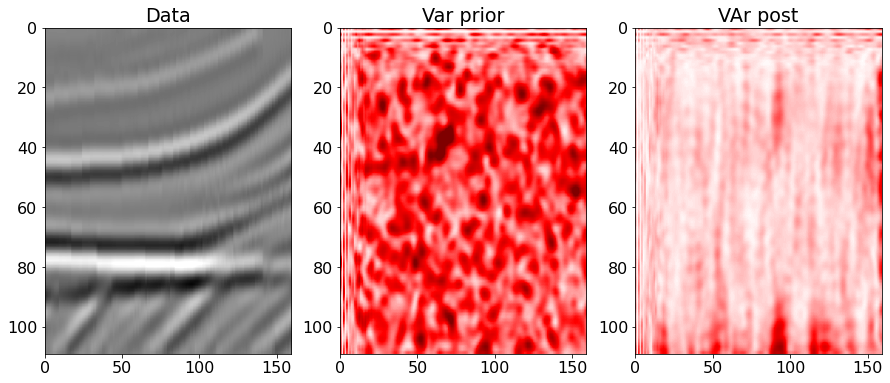

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))
axs[0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(np.diag(Cm_prior).reshape(nz, nx),
              cmap='seismic', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max())
axs[1].set_title('Var prior')
axs[1].axis('tight')
axs[2].imshow(np.diag(Cm_post).reshape(nz, nx), cmap='seismic',
              extent = (x[0], x[-1], z[-1], z[0]),
              vmin=-0.6*Cm_prior.max(), vmax=0.6*Cm_prior.max())
axs[2].set_title('VAr post')
axs[2].axis('tight');